# Deep Leakage from Gradients

梯度的深度泄漏
本笔记本显示了“梯度深度泄漏”中描述的攻击示例。

论文网址：https://papers.nips.cc/paper/2019/hash/60a6c4002cc7b29142def8871531281a-Abstract.html

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# 摘要

传递梯度是现代多节点学习系统中广泛使用的方案（例如分布式训练、协作学习）。 长期以来，人们曾经相信梯度共享是安全的：即训练集不会因梯度共享而泄漏。 然而，在本文中，我们证明我们可以从公开共享的梯度中获得私人训练集。 泄漏只需要几个梯度步骤来处理，并且可以获得原始训练集而不是相似的替代方案。 我们将这种泄漏命名为 \textit{梯度深度泄漏}，并在计算机视觉和自然语言处理任务上实际验证了我们的算法的有效性。 我们根据经验表明，我们的攻击比以前的方法要强大得多，从而提高了人们重新考虑梯度安全性的意识。 我们还讨论了一些可能的策略来防止这种深度泄漏。

In [2]:
# !pip install breaching

# **启动**

In [4]:
# try:
#     import breaching
# except ModuleNotFoundError:
#     # You only really need this safety net if you want to run these notebooks directly in the examples directory
#     # Don't worry about this if you installed the package or moved the notebook to the main directory.
#     import os; os.chdir("..")
import breaching

import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 初始化 cfg 对象和系统设置：

这将加载完整的配置对象。 这包括用例和威胁模型的配置（如 cfg.case）以及超参数和攻击的实施（如 cfg.attack）。 所有参数都可以在下面修改，或者使用 overrides= 覆盖，就像它们是命令行参数一样。

In [5]:
cfg = breaching.get_config(overrides=["case=1_single_image_small", "attack=deepleakage"])

device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

/root/miniconda3/lib/python3.8/site-packages/breaching/__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case single_image_small with server type honest_but_curious.


{'device': device(type='cuda'), 'dtype': torch.float32}

# 此处修改配置选项

您可以使用 .attribute 访问权限来修改攻击的任何配置，或以下情况：

In [6]:
cfg.case.data.partition="unique-class"
cfg.case.user.user_idx = 1
cfg.case.user.provide_labels=False # 这种攻击可以通过优化重建标签信息。

# 实例化所有参与者


以下行生成“服务器”、“用户”和“攻击者”对象并打印其配置的概述。

In [7]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture ConvNet loaded with 2,904,970 parameters and 3,208 buffers.
Overall this is a data ratio of     946:1 for target shape [1, 3, 32, 32] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ConvNet
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationJointAttacker) with settings:
    Hyperparameter Template: deep-leakage

    Objective: Euclidean loss with scale=1.0 and task reg=0.0
    Regularizers: 
    Augmentations: 

    Optimization Setup:
        opti

这段配置描述了一个机器学习模型的训练和评估过程，其中涉及到用户、服务器以及攻击者三个主要角色。以下是对配置中各部分的解释：

1. **数据信息:**
   - 已下载和验证的文件。
   - 模型期望的输入形状为 [1, 3, 32, 32]，表示每个数据点是一个3通道的32x32图像。
   - 数据点的数量为1，对应于`num_queries=1`。

2. **用户 (UserSingleStep) 配置:**
   - 用户提供的数据点数目为1。
   - 用户不提供标签（False）。
   - 用户不提供缓冲区（False）。
   - <span class="mark">数据集：CIFAR10
   - <span class="mark">用户数量：1</span></span>

3. **服务器 (HonestServer) 配置:**
   - 服务器是一个Honest-but-curious模型，即它会按照规定执行任务，但有可能会探查数据。
   - 计划进行1次查询。
   - 模型采用<span class="mark">ConvNet</span>结构，参数数量为2,904,970。
   - 有3,208个缓冲区。
   - 服务器不具备外部或公共数据。

4. **攻击者 (OptimizationJointAttacker) 配置:**
   - 使用深度泄漏（deep-leakage）的超参数模板。
   - 优化目标是欧几里得损失，比例为1.0，任务正则化项为0.0。
   - 没有使用正则化项。
   - 采用L-BFGS优化器。
   - 最大迭代次数为1200。
   - 优化步长为1.0。
   - 未进行有符号（signed）处理。
   - 未限制参数在某个范围内（boxed为False）。
   - 没有步长衰减。
   - 拉格朗日噪声为0.0。
   - 没有预热期。
   - 没有梯度剪裁。
   - 每100次迭代进行一次回调。

# 模拟一个受到攻击的 FL 协议

这个交换是一个联邦学习协议中的单个查询的模拟。服务器发送一个 server_payload，用户根据他们的私有本地数据计算一个更新。这个用户更新是 shared_data，包含了例如在最简单的情况下模型的参数梯度。true_user_data 也被 .compute_local_updates 返回，但是当然不会被转发给服务器或者攻击者，只用于（我们的）分析。

In [8]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


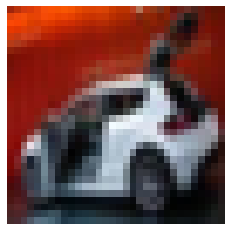

In [9]:
user.plot(true_user_data)

# 重构用户数据：
现在我们发起攻击，只根据 server_payload 和 shared_data 重构用户数据。

对于这种攻击，我们还与攻击者共享来自恶意服务器的秘密信息（server.secrets），这里是印记模块的位置和结构。

In [10]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.1087 |  Task loss: 2.3259 | T: 8.68s |  Label Entropy: 0.0000.
| It: 101 | Rec. loss: 0.0027 |  Task loss: 2.3258 | T: 67.59s |  Label Entropy: 0.0000.
| It: 201 | Rec. loss: 0.0017 |  Task loss: 2.3258 | T: 67.56s |  Label Entropy: 0.0000.
| It: 301 | Rec. loss: 0.0018 |  Task loss: 2.3258 | T: 66.16s |  Label Entropy: 0.0000.
| It: 401 | Rec. loss: 0.0020 |  Task loss: 2.3258 | T: 66.75s |  Label Entropy: 0.0000.
| It: 501 | Rec. loss: 0.0020 |  Task loss: 2.3258 | T: 66.50s |  Label Entropy: 0.0000.
| It: 601 | Rec. loss: 0.0021 |  Task loss: 2.3258 | T: 66.50s |  Label Entropy: 0.0000.
| It: 701 | Rec. loss: 0.0017 |  Task loss: 2.3258 | T: 65.95s |  Label Entropy: 0.0000.
| It: 801 | Rec. loss: 0.0018 |  Task loss: 2.3258 | T: 66.28s |  Label Entropy: 0.0000.
| It: 901 | Rec. loss: 0.0021 |  Task loss: 2.3258 | T: 66.90s |  Label Entropy: 0.0000.
| It: 1101 | Rec. loss: 0.0019 |  Task loss: 2.3258 | T: 66.16s |  Label Entropy: 0.0000.
| It: 1200 | Rec. loss:

In [11]:
!pip install kornia

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 756 kB 4.4 MB/s eta 0:00:01


In [12]:
!pip install pytorch_wavelets

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 54 kB 2.9 MB/s eta 0:00:011


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [15]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload],
                                    server.model, order_batch=True, compute_full_iip=False,
                                    cfg_case=cfg.case, setup=setup)

Files already downloaded and verified
METRICS: | MSE: 0.0046 | PSNR: 23.34 | FMSE: 6.5023e-12 | LPIPS: 0.00|
 R-PSNR: 23.34 | IIP-pixel: 100.00% | SSIM: nan | max R-PSNR: 23.34 | max SSIM: nan | Label Acc: 0.00%


And finally, we also plot the reconstructed data:

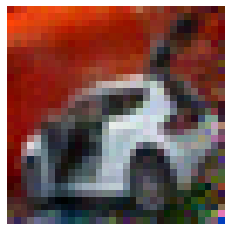

In [16]:
user.plot(reconstructed_user_data)

# 注释

* 可以用 `case.model=lenet_zhu` 获取原始论文中的模型
* 这种攻击通常有效，但对于更具挑战性的模型可能会陷入不良的局部最小值。多次重启攻击，（例如，通过设置 `attack.restarts.num_trials=16`）可以帮助解决这个问题。